# Problem

We have get accrued interest and the full price usig Excel function.

Here we want to use regressiong methods to get the yield curve, the steps are as follows：
1. Load full price of the bonds from data.
2. Build the coupon matrix C, which the futures payments of each bonds.
3. Deal with the sparsity and singularity of the coupon matrix.
4. Using regression methods to calculate the discount factor for each term.
5. Get yield from discount.
6. Using a regression model to fit the yield curve.

![problem](./pic/problem.png)

# Data Preprocessing

data loading and basic configuration



In [1]:
import numpy as np
import pandas as pd
import dateutil
import scipy.linalg as la
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

# basic configuration
current_date = pd.to_datetime('09/14/2020')
par = 100
frequency = 2

df = pd.read_excel('Yield Curve Bootstrapping.xlsx', skiprows=6)

preprocess data, make unique identifier for bonds

In [2]:
def preprocess_data(df):
    # use maturity+coupon as a bond's unique identifier
    df['bond_id'] = df['MATURITY'].str.cat(df['COUPON'].apply(str), sep='_')
    return df.set_index('bond_id')
df = preprocess_data(df)
df.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,MaturityDate,SettlementDate,LastCouponDate,NextCouponDate,IssueDate,FirstInterestDate,AnnualCouponRate,AccruedInterest,CleanPrice,FullPrice
bond_id,,,,,,,,,,,,,,,,
9/30/2020_1.375,9/30/2020,1.375,100.014,100.020,unch.,-0.1489,2020-09-30,2020-09-15,2020-03-31,2020-09-30,2020-03-31,2020-09-30,0.01375,0.630208,100.017,100.647208
9/30/2020_2.0,9/30/2020,2.000,100.024,100.030,0.002,-0.2844,2020-09-30,2020-09-15,2020-03-31,2020-09-30,2020-03-31,2020-09-30,0.02000,0.916667,100.027,100.943667
9/30/2020_2.75,9/30/2020,2.750,100.032,100.036,-0.002,-0.1080,2020-09-30,2020-09-15,2020-03-31,2020-09-30,2020-03-31,2020-09-30,0.02750,1.260417,100.034,101.294417
10/15/2020_1.625,10/15/2020,1.625,100.040,100.044,0.004,-0.0900,2020-10-15,2020-09-15,2020-04-15,2020-10-15,2020-04-15,2020-10-15,0.01625,0.677083,100.042,100.719083
10/31/2020_1.375,10/31/2020,1.375,100.050,100.054,0.004,0.0000,2020-10-31,2020-09-15,2020-04-30,2020-10-31,2020-04-30,2020-10-31,0.01375,0.515625,100.052,100.567625


get all possible coupon dates

In [3]:
# get all coupon dates
def get_all_coupon_dates(start_date, end_date):
    dates_monthend = pd.date_range(start=start_date, end=end_date, freq=pd.offsets.MonthEnd(1))
    dates_monthmid = (dates_monthend + pd.to_timedelta(15, 'D'))
    return dates_monthend.append(dates_monthmid).sort_values()

date_max = df['MaturityDate'].max()
all_coupon_dates = get_all_coupon_dates(current_date, date_max)
print(all_coupon_dates)

DatetimeIndex(['2020-09-30', '2020-10-15', '2020-10-31', '2020-11-15',
               '2020-11-30', '2020-12-15', '2020-12-31', '2021-01-15',
               '2021-01-31', '2021-02-15',
               ...
               '2050-03-31', '2050-04-15', '2050-04-30', '2050-05-15',
               '2050-05-31', '2050-06-15', '2050-06-30', '2050-07-15',
               '2050-07-31', '2050-08-15'],
              dtype='datetime64[ns]', length=718, freq=None)


# Build Coupon Matrix

In [4]:
bond_prices = df['FullPrice']
coupon_matrix = pd.DataFrame(index=all_coupon_dates, columns=df.index.values)

def get_coupon_dates(start_date, end_date):
    if end_date.day == 15:
        coupon_dates = []
        coupon_date = end_date
        while coupon_date >= start_date:
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date - dateutil.relativedelta.relativedelta(months=12/frequency)
        return pd.Index(sorted(coupon_dates))
    else:
        periods = int((maturity-all_coupon_dates[0]).days/180+1)
        coupon_dates = pd.date_range(end=maturity, freq=pd.offsets.MonthEnd(12/frequency), periods=periods)
        coupon_dates = coupon_dates[coupon_dates >= start_date]
        return coupon_dates

# generate coupon_matrix
for bond_id in df.index:
    maturity = df.loc[bond_id, 'MaturityDate']
    coupon_payment = df.loc[bond_id, 'COUPON']/frequency
    coupon_dates = get_coupon_dates(all_coupon_dates[0], maturity)
    coupon_matrix.loc[coupon_dates, bond_id] = coupon_payment
    coupon_matrix.loc[coupon_dates[-1], bond_id] = coupon_matrix.loc[coupon_dates[-1], bond_id] + par
    
coupon_matrix.head()

,9/30/2020_1.375,9/30/2020_2.0,9/30/2020_2.75,10/15/2020_1.625,10/31/2020_1.375,10/31/2020_1.75,10/31/2020_2.875,11/15/2020_1.75,11/15/2020_2.625,11/30/2020_1.625,...,5/15/2048_3.125,8/15/2048_3.0,11/15/2048_3.375,2/15/2049_3.0,5/15/2049_2.875,8/15/2049_2.25,11/15/2049_2.375,2/15/2050_2.0,5/15/2050_1.25,8/15/2050_1.375
2020-09-30,100.688,101,101.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-15,NaN,NaN,NaN,100.812,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,NaN,NaN,100.688,100.875,101.438,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.875,101.312,NaN,...,1.5625,NaN,1.6875,NaN,1.4375,NaN,1.1875,NaN,0.625,NaN
2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


![coupon_matrix](./pic/coupon_matrix.png)

![coupon_matrix2](./pic/coupon_matrix2.png)

Drop all the coupon dates where there is no payments.

In [5]:
data_numbers = (~pd.isnull(coupon_matrix)).sum(axis=1)
clean_coupon_dates = all_coupon_dates[data_numbers > 0]
coupon_matrix = coupon_matrix.fillna(0)
clean_coupon_matrix = coupon_matrix.loc[clean_coupon_dates, :]

# Deal with coupon matrix singularity

Data in range 11/15/2030-11/15/2038 are not reliable because the US government had stopped issuing bonds for years. Therefore, we aggregate the coupon payment at the midpoint time. And the payments for several coupon dates are the same, which will introduce singularity to the regression.

![singularity](./pic/singularity.png)

In [6]:
def remove_singularity(singular_coupon_matrix, start_time, end_time):
    singular_period_matrix = singular_coupon_matrix[start_time: end_time]
    midpoint_time = singular_period_matrix.index[int(len(singular_period_matrix)/2)]
    # midpoint_time = singular_period_matrix.index[-1]
    coupon_sum = singular_period_matrix.sum(axis=0)

    nonsingular_coupon_matrix = singular_coupon_matrix[(singular_coupon_matrix.index<start_time) | (singular_coupon_matrix.index>end_time)]
    nonsingular_coupon_matrix.loc[midpoint_time, :] = coupon_sum
    nonsingular_coupon_matrix = nonsingular_coupon_matrix.sort_index()
    return nonsingular_coupon_matrix

def remove_singularity2(singular_coupon_matrix, start_time, end_time):
    for idx in singular_coupon_matrix[start_time: end_time].index:
        for col in singular_coupon_matrix.columns:
            singular_coupon_matrix.loc[idx, col] = singular_coupon_matrix.loc[idx, col] + np.random.normal(0, 1)

    return singular_coupon_matrix

start_time = pd.to_datetime('11/15/2030')
end_time = pd.to_datetime('11/15/2038')
clean_coupon_matrix = remove_singularity(clean_coupon_matrix, start_time, end_time)
clean_coupon_matrix

,9/30/2020_1.375,9/30/2020_2.0,9/30/2020_2.75,10/15/2020_1.625,10/31/2020_1.375,10/31/2020_1.75,10/31/2020_2.875,11/15/2020_1.75,11/15/2020_2.625,11/30/2020_1.625,...,5/15/2048_3.125,8/15/2048_3.0,11/15/2048_3.375,2/15/2049_3.0,5/15/2049_2.875,8/15/2049_2.25,11/15/2049_2.375,2/15/2050_2.0,5/15/2050_1.25,8/15/2050_1.375
2020-09-30,100.6875,101.0,101.375,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.000,0.0000
2020-10-15,0.0000,0.0,0.000,100.8125,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.000,0.0000
2020-10-31,0.0000,0.0,0.000,0.0000,100.6875,100.875,101.4375,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.000,0.0000
2020-11-15,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,100.875,101.3125,0.0000,...,1.5625,0.0,1.6875,0.0,1.4375,0.000,1.1875,0.0,0.625,0.0000
2020-11-30,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,100.8125,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-08-15,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,101.125,0.0000,1.0,0.000,0.6875
2049-11-15,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,101.1875,0.0,0.625,0.0000
2050-02-15,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,101.0,0.000,0.6875
2050-05-15,0.0000,0.0,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0000,0.000,0.0000,0.0,100.625,0.0000


# Regression to calculate discount factor and yield

$$
C=\begin{pmatrix}
c_{11} & \dots & c_{1m}\\
  & \ddots & \vdots\\
c_{n1} & & c_{nm}
\end{pmatrix}_{n \times m}
$$

$$
p=\begin{pmatrix}
p_{1}\\
\vdots\\
p_{n}
\end{pmatrix}_{n \times 1}
$$

$$
d=\begin{pmatrix}
d_{1}\\
\vdots\\
d_{m}
\end{pmatrix}_{m \times 1}
$$

$$
p=Cd
$$

$$d=(C^\mathrm{T}C)^{-1}C^\mathrm{T}p $$

$$yield=\frac{\ln(discount factor)}{(-t)} $$

In [7]:
# solve for discount factor
discount_factors = pd.DataFrame(index=clean_coupon_matrix.index, dtype='float64')

C = clean_coupon_matrix.values.T
p = bond_prices.values
d = np.dot(np.dot(np.linalg.inv(np.dot(C.T, C)), C.T), p)

# solve for yield
discount_factors['discount_facotr'] = d
discount_factors['days'] = (clean_coupon_matrix.index - current_date).days
discount_factors['years'] = discount_factors['days']/365
discount_factors['yield'] = np.log(d)/(-discount_factors['years'])
discount_factors.head()

,discount_facotr,days,years,yield
2020-09-30,0.999411,16,0.043836,0.013446
2020-10-15,0.999073,31,0.084932,0.010915
2020-10-31,0.998294,47,0.128767,0.013263
2020-11-15,0.997291,62,0.169863,0.015967
2020-11-30,0.996960,77,0.210959,0.014435


# Smooth the yield to get yield curve

$$yield=a_1*t+a_2*t^2+a_3*\sqrt{t}+a_4*e^t+a_5*\ln{t}$$

Text(0.5, 1.0, 'Bootstrapping Using Regression Analysis')

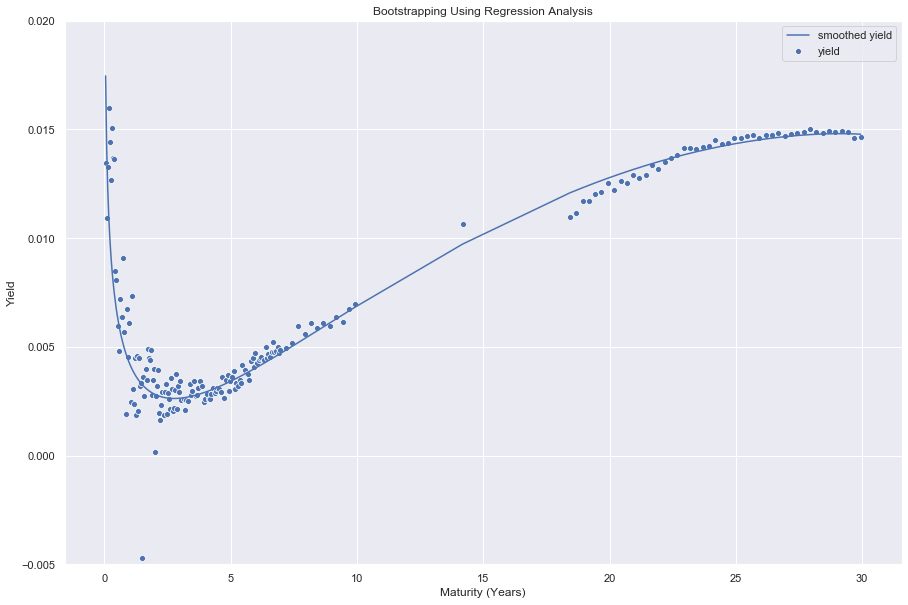

In [8]:
# smooth
X = discount_factors[['years']]
X['t'] = X['years']
X['t^2'] = X['t'] ** 2
X['t^0.5'] = X['t'] ** 0.2
X['e^t'] = np.exp(X['t'])
X['ln(t)'] = np.log(X['t'])
y = discount_factors['yield']

reg = LinearRegression().fit(X[['t', 't^2', 't^0.5', 'e^t', 'ln(t)']], y)
y_hat = reg.predict(X[['t', 't^2', 't^0.5', 'e^t', 'ln(t)']])
r_predict = pd.Series(y_hat, index=discount_factors.index)

plt.figure(figsize=(15,10))
plt.plot((r_predict.index-current_date).days/365, r_predict.values, label='smoothed yield')
sns.scatterplot((y.index-current_date).days/365, y.values, label='yield')
plt.ylim([-0.005, 0.02])
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.title('Bootstrapping Using Regression Analysis')

# Output Results

In [9]:
discount_factors['yield_fit'] = y_hat
discount_factors.to_csv('Yield Curve Fit.csv')